# **CV ASSIGNMENT NO. 2**
#  (**ANN VS CNN**)

## **Importing Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import numpy as np

### **Device Configure**

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Data Transform**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## **Loading Dataset**

In [ ]:
# Fashion MNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


## **Fashion MNIST Images**

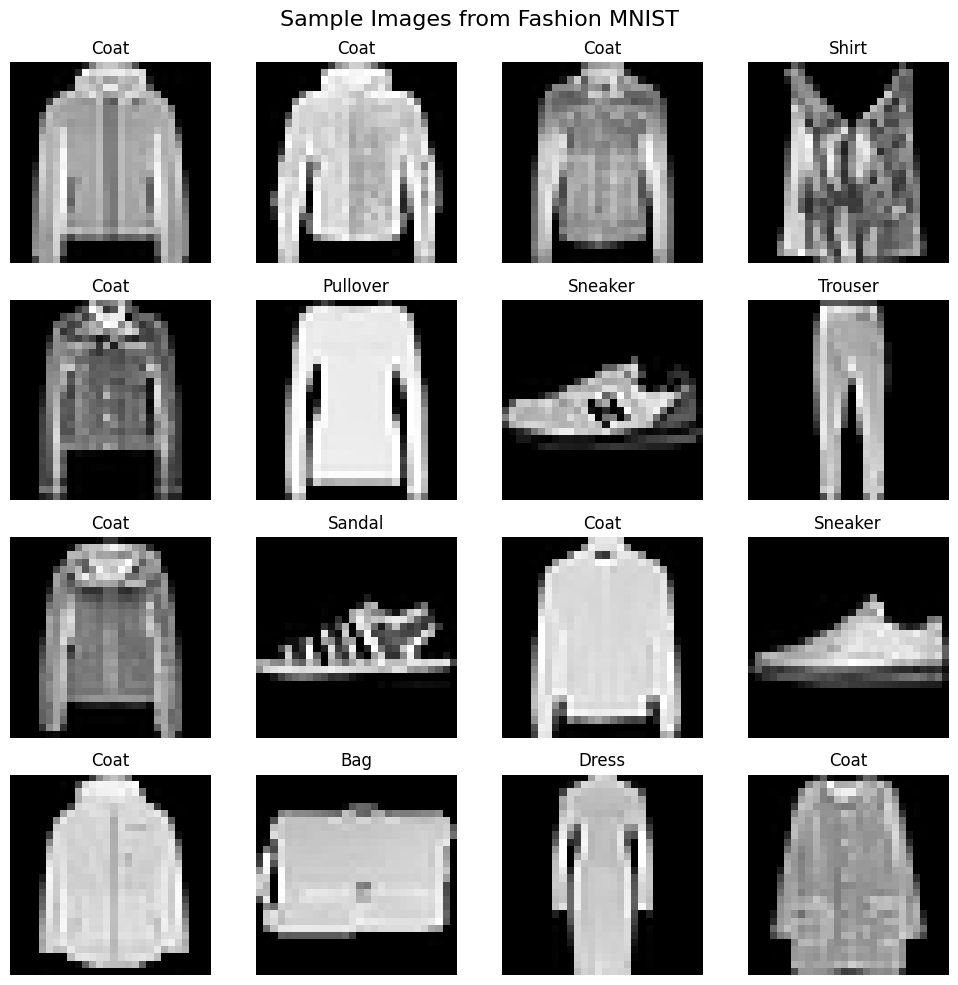

In [ ]:
class_names = train_dataset.classes

def show_sample_images(dataset, num_images=16):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
        img = images[i].squeeze()
        plt.imshow(img, cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.suptitle("Sample Images from Fashion MNIST", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset)


## **ANN Architecture**

•	ANNs are fully connected networks where every neuron in a layer is connected to every neuron in the subsequent layer.
•	They are suitable for structured data but may not be ideal for image data since they do not preserve spatial relationships (such as 2D structure in images).


In [ ]:
class ANN(nn.Module):
    def __init__(self, layers):
        super(ANN, self).__init__()
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)

def build_ann(layers_config):
    layers = []
    input_size = 28*28
    for layer_size in layers_config:
        layers.append(nn.Linear(input_size, layer_size))
        layers.append(nn.ReLU())
        input_size = layer_size
    layers.append(nn.Linear(input_size, 10))  # Output layer
    return ANN(layers).to(device)



## **ANN Models**

In [ ]:
ann_models = {
    "Shallow ANN": build_ann([128, 64]),
    "Deeper ANN": build_ann([256, 128, 64, 32]),
    "Very Deep ANN": build_ann([512, 256, 128, 64, 32, 16])
}


## **CNN Architecture**

•	CNNs are designed specifically for image data, and they perform better than ANNs on such data because they learn spatial hierarchies through convolutional layers and pooling layers.

In [ ]:
class CNN(nn.Module):
    def __init__(self, conv_layers, fc_units):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(fc_units, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.fc(x)

def build_cnn(conv_specs):
    conv_layers = []
    in_channels = 1
    size = 28
    for out_channels in conv_specs:
        conv_layers += [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        in_channels = out_channels
        size //= 2
    fc_input_size = in_channels * size * size
    return CNN(conv_layers, fc_input_size).to(device)


## **CNN Models**

In [ ]:
cnn_models = {
    "Basic CNN": build_cnn([32, 64]),
    "Medium CNN": build_cnn([64, 128, 256]),
    "Advanced CNN": build_cnn([128, 256, 512, 256])
}


## **Training & Evaluation**

In [ ]:
def train_and_evaluate(model, name, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss = loss_sum / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        correct, total, loss_sum = 0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                loss_sum += loss.item()
                correct += (output.argmax(1) == y).sum().item()
                total += y.size(0)
        test_loss = loss_sum / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"[{name}] Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    training_time = time.time() - start_time
    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_acc": train_accuracies,
        "test_acc": test_accuracies,
        "training_time": training_time
    }


## **Results**

In [ ]:
results = {}

for name, model in ann_models.items():
    print(f"\nTraining {name}")
    results[name] = train_and_evaluate(model, name)

for name, model in cnn_models.items():
    print(f"\nTraining {name}")
    results[name] = train_and_evaluate(model, name)



Training Shallow ANN
[Shallow ANN] Epoch 1/10 - Train Acc: 0.8136, Test Acc: 0.8410
[Shallow ANN] Epoch 2/10 - Train Acc: 0.8614, Test Acc: 0.8487
[Shallow ANN] Epoch 3/10 - Train Acc: 0.8739, Test Acc: 0.8633
[Shallow ANN] Epoch 4/10 - Train Acc: 0.8810, Test Acc: 0.8544
[Shallow ANN] Epoch 5/10 - Train Acc: 0.8883, Test Acc: 0.8734
[Shallow ANN] Epoch 6/10 - Train Acc: 0.8951, Test Acc: 0.8770
[Shallow ANN] Epoch 7/10 - Train Acc: 0.8995, Test Acc: 0.8750
[Shallow ANN] Epoch 8/10 - Train Acc: 0.9036, Test Acc: 0.8708
[Shallow ANN] Epoch 9/10 - Train Acc: 0.9055, Test Acc: 0.8800
[Shallow ANN] Epoch 10/10 - Train Acc: 0.9104, Test Acc: 0.8787

Training Deeper ANN
[Deeper ANN] Epoch 1/10 - Train Acc: 0.7917, Test Acc: 0.8323
[Deeper ANN] Epoch 2/10 - Train Acc: 0.8559, Test Acc: 0.8577
[Deeper ANN] Epoch 3/10 - Train Acc: 0.8711, Test Acc: 0.8611
[Deeper ANN] Epoch 4/10 - Train Acc: 0.8822, Test Acc: 0.8715
[Deeper ANN] Epoch 5/10 - Train Acc: 0.8868, Test Acc: 0.8715
[Deeper ANN] Epo

## **Plots**

In [ ]:
def plot_metrics(results):
    for name, res in results.items():
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        ax[0].plot(res['train_losses'], label='Train Loss', color='blue')
        ax[0].plot(res['test_losses'], label='Test Loss', color='red')
        ax[0].set_title(f'{name} - Loss over Epochs')
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].plot(res['train_acc'], label='Train Accuracy', color='green')
        ax[1].plot(res['test_acc'], label='Test Accuracy', color='orange')
        ax[1].set_title(f'{name} - Accuracy over Epochs')
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

        plt.suptitle(name, fontsize=14)
        plt.tight_layout()
        plt.show()


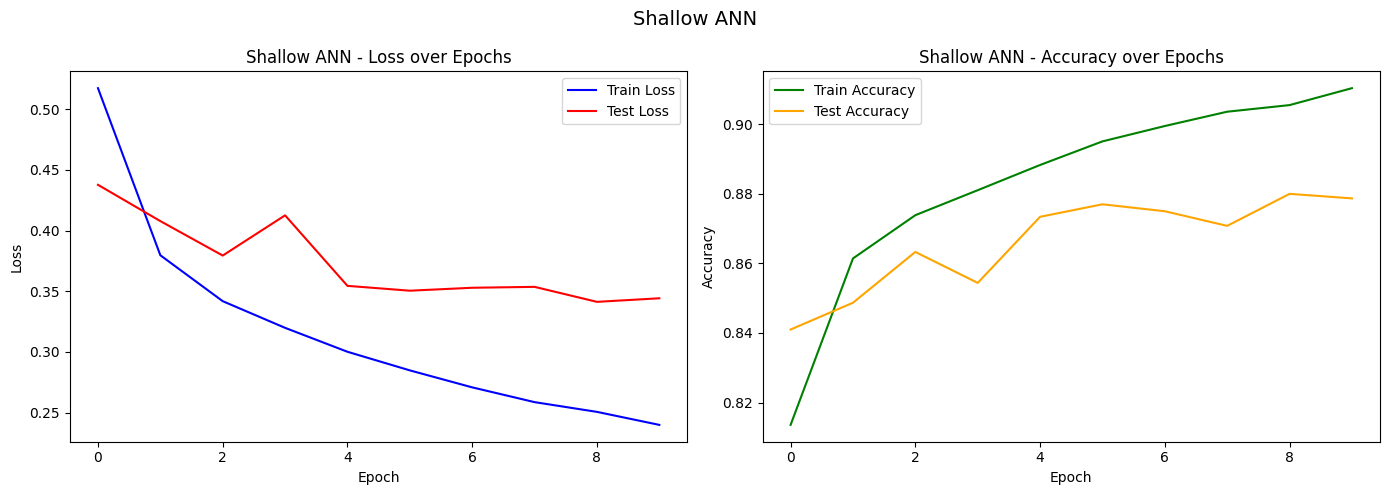

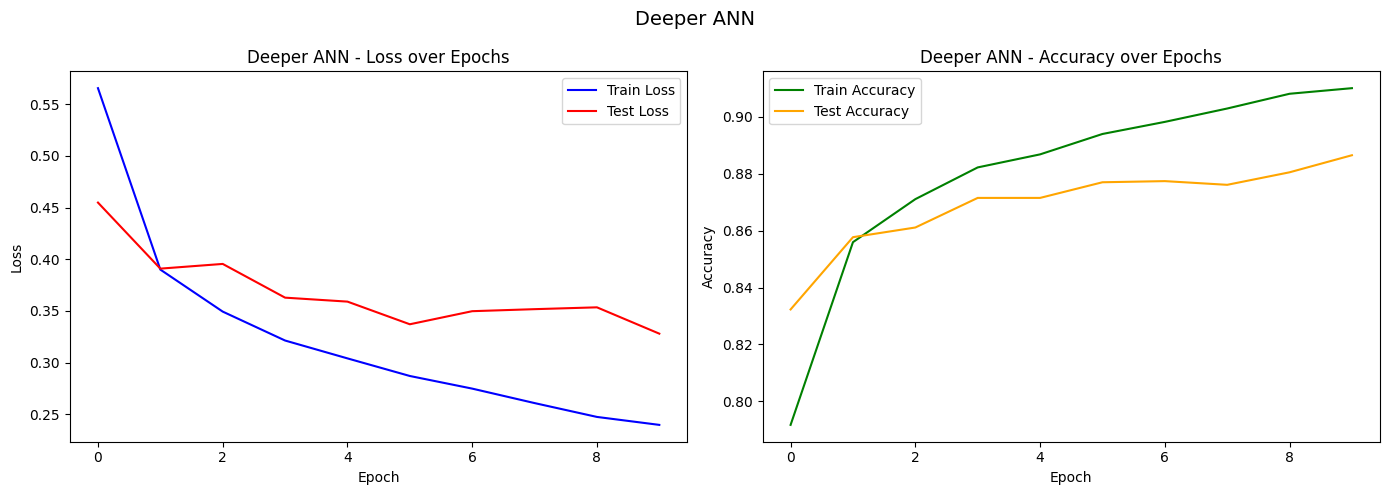

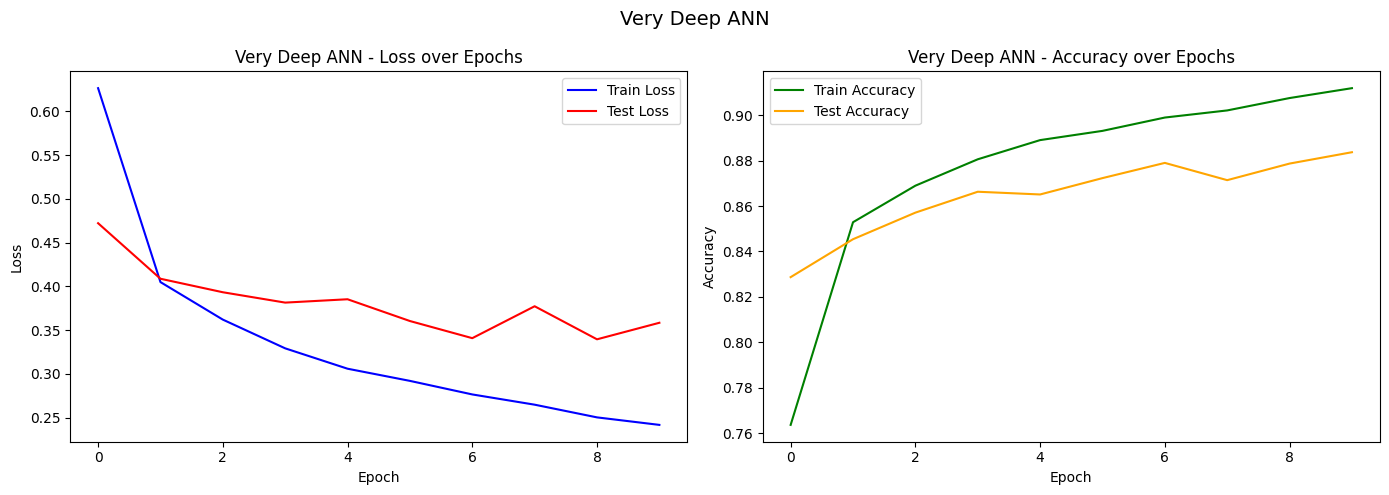

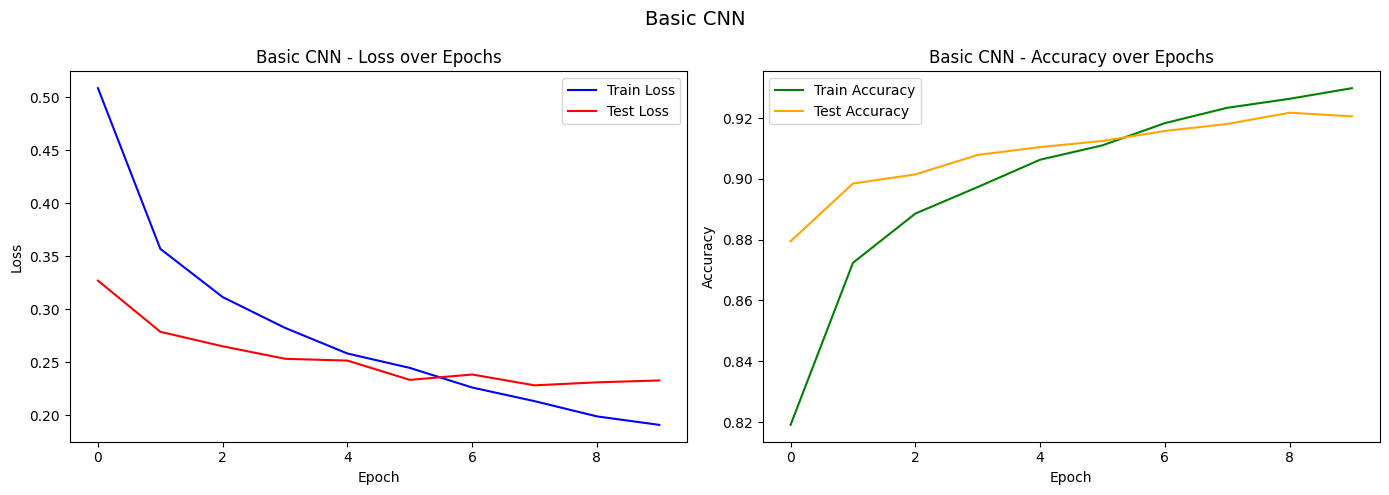

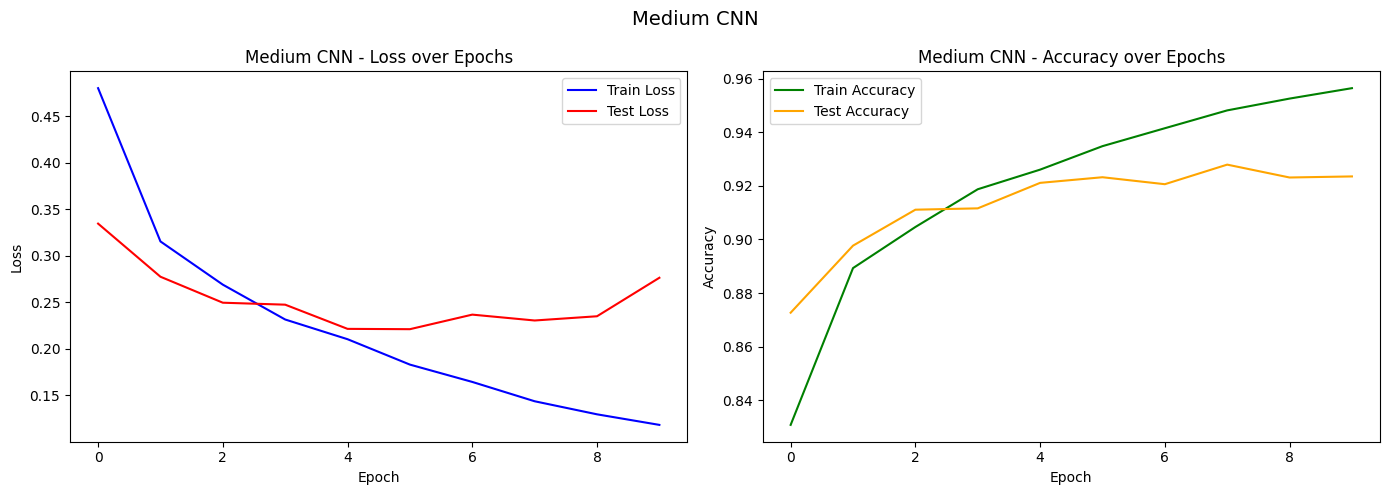

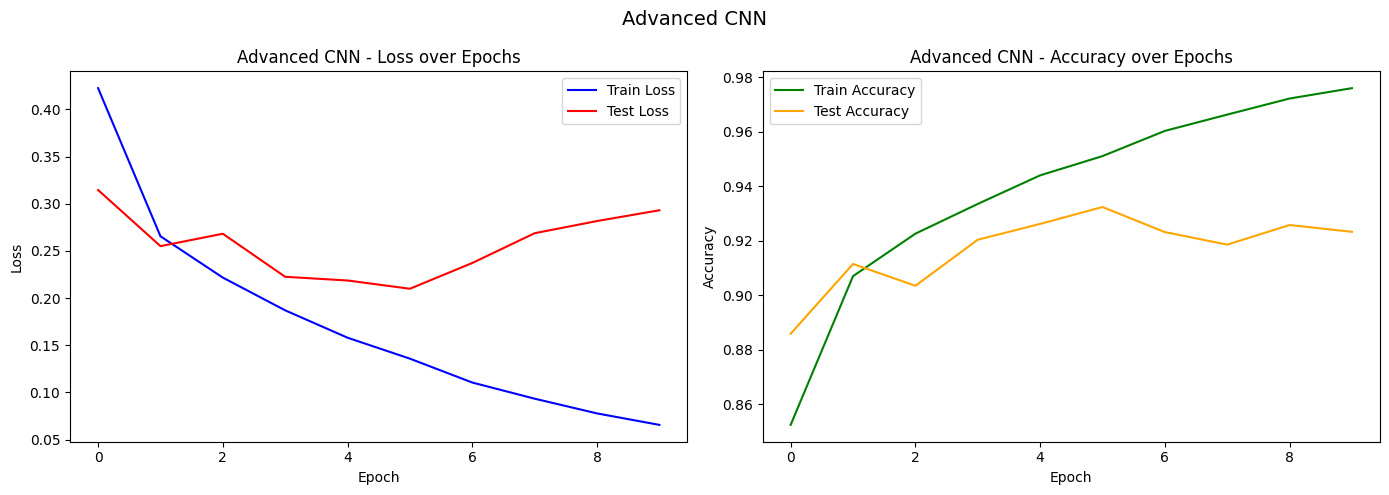

In [ ]:
plot_metrics(results)

## **Confusion Matrices**

In [ ]:
def plot_conf_matrix(model, model_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            output = model(x)
            preds = output.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(xticks_rotation=45, cmap='Blues', ax=ax)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


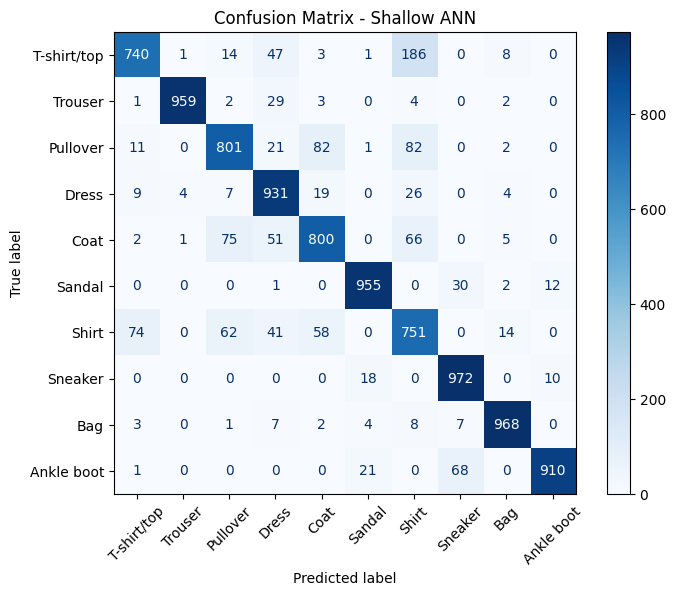

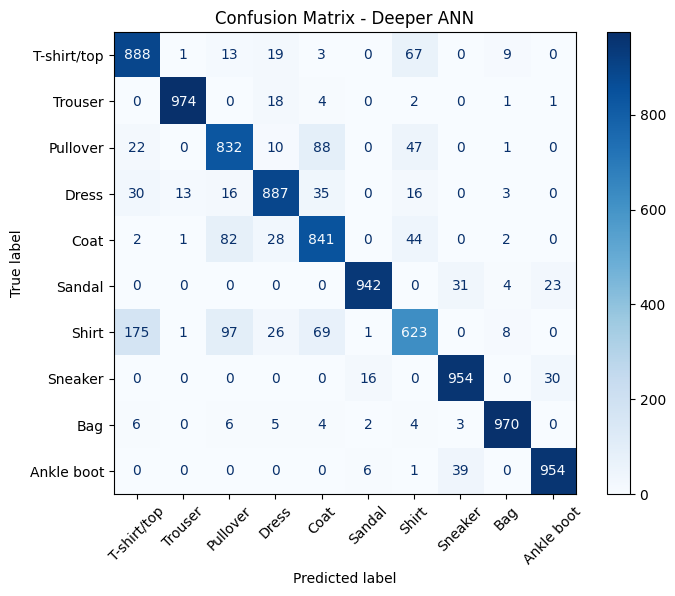

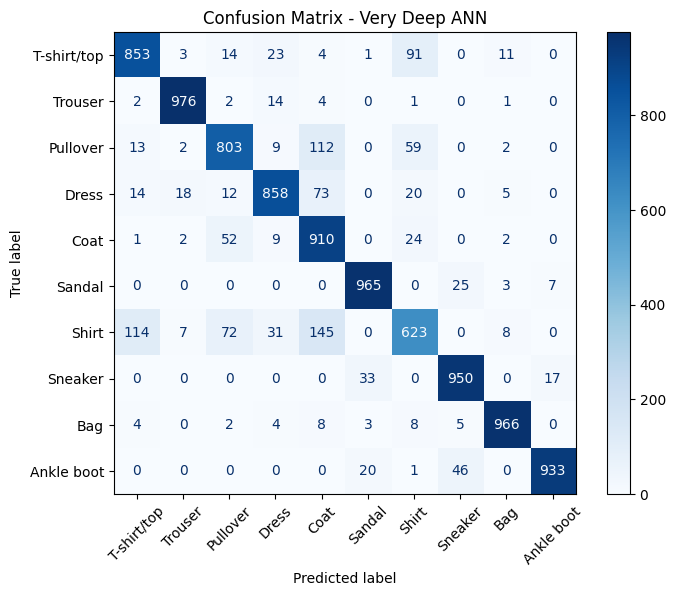

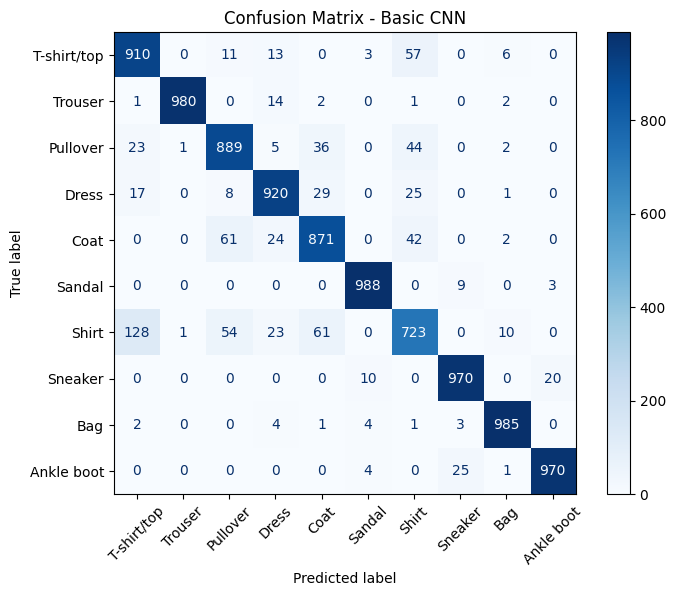

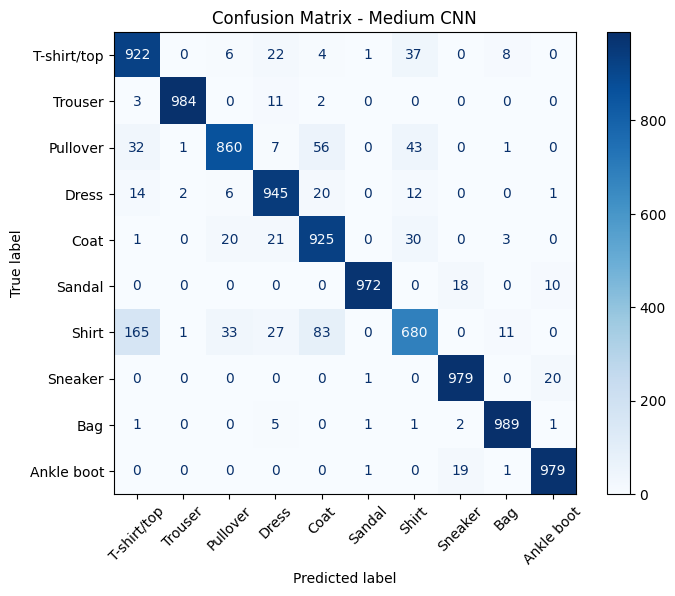

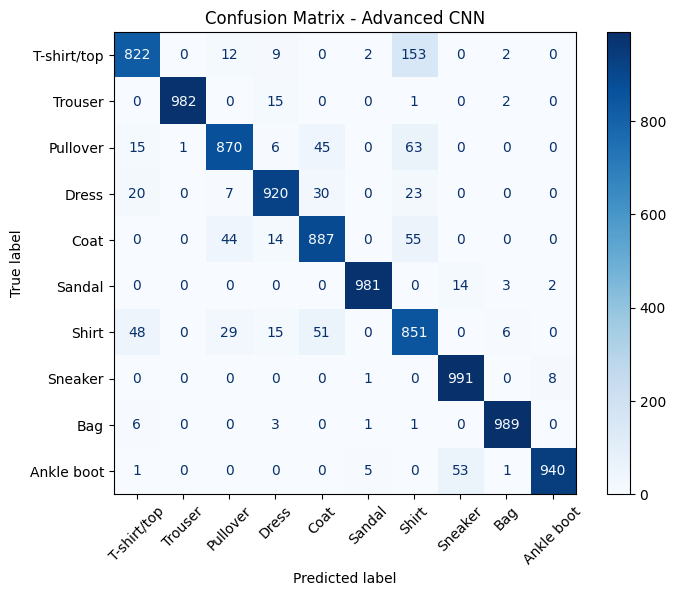

In [ ]:
trained_models = {**ann_models, **cnn_models}

for name, model in trained_models.items():
    plot_conf_matrix(model, name)

## **Results Table**

In [ ]:
import pandas as pd

def generate_results_table(results):
    rows = []
    for name, r in results.items():
        rows.append({
            'Model': name,
            'Train Acc (%)': round(r['train_acc'][-1] * 100, 2),
            'Test Acc (%)': round(r['test_acc'][-1] * 100, 2),
            'Train Loss': round(r['train_losses'][-1], 4),
            'Test Loss': round(r['test_losses'][-1], 4),
            'Training Time (s)': round(r['training_time'], 2),
            'Overfitting Gap (%)': round((r['train_acc'][-1] - r['test_acc'][-1]) * 100, 2)
        })
    df = pd.DataFrame(rows)
    return df

results_df = generate_results_table(results)
print(results_df)


           Model  Train Acc (%)  Test Acc (%)  Train Loss  Test Loss  \
0    Shallow ANN          91.04         87.87      0.2399     0.3442   
1     Deeper ANN          91.01         88.65      0.2398     0.3280   
2  Very Deep ANN          91.19         88.37      0.2416     0.3583   
3      Basic CNN          92.99         92.06      0.1911     0.2330   
4     Medium CNN          95.64         92.35      0.1183     0.2764   
5   Advanced CNN          97.60         92.33      0.0656     0.2931   

   Training Time (s)  Overfitting Gap (%)  
0             142.25                 3.17  
1             141.23                 2.36  
2             146.91                 2.82  
3             158.73                 0.93  
4             191.94                 3.29  
5             243.30                 5.27  


## **HeatMap**

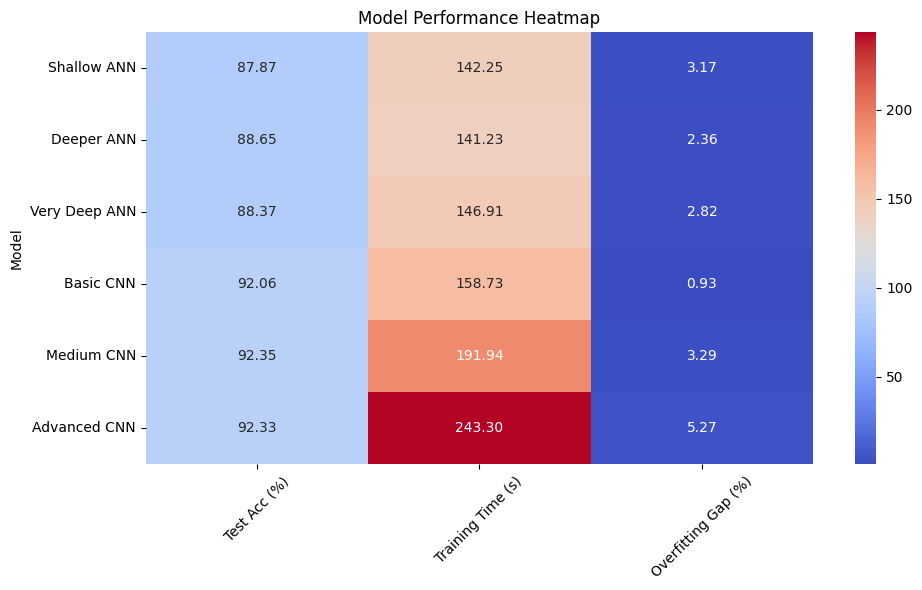

In [ ]:
plt.figure(figsize=(10, 6))
heatmap_data = results_df.set_index('Model')[['Test Acc (%)', 'Training Time (s)', 'Overfitting Gap (%)']]
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Model Performance Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## **Hyperparameter Tuning**

## **Data Augmentation**

In [ ]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Zoom effect
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## **Tuning Setup for ANN & CNN**

 ### **Explanation of Names:**

ANN / CNN	Model type

BS32	Batch size

LR1e-3	Learning rate (e.g., 0.001)

DO0.5	Dropout rate

Aug / NoAug	Augmentation applied (CNN only)

In [ ]:
ann_tuning_setups = [
    {"name": "ANN_BS32_LR1e-3_DO0.2", "layers": [256, 128, 64], "batch_size": 32, "lr": 0.001, "dropout": 0.2},
    {"name": "ANN_BS64_LR1e-4_DO0.5", "layers": [256, 128, 64], "batch_size": 64, "lr": 0.0001, "dropout": 0.5},
    {"name": "ANN_BS128_LR1e-3_DO0.5", "layers": [256, 128, 64], "batch_size": 128, "lr": 0.001, "dropout": 0.5}
]

cnn_tuning_setups = [
    {"name": "CNN_BS32_LR1e-3_NoAug", "layers": [128, 64], "batch_size": 32, "lr": 0.001, "use_aug": False},
    {"name": "CNN_BS64_LR1e-4_Aug", "layers": [128, 64], "batch_size": 64, "lr": 0.0001, "use_aug": True}
]


## **Running the Experiments**

In [ ]:
def build_ann(layers_config, dropout=0.5):
    layers = []
    input_size = 28 * 28
    for layer_size in layers_config:
        layers.append(nn.Linear(input_size, layer_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        input_size = layer_size
    layers.append(nn.Linear(input_size, 10))
    return ANN(layers).to(device)


## **Models and Evaluation**

In [ ]:

def build_cnn(layers, dropout=0.5):
    model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(dropout),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(dropout),

        nn.Flatten(),
        nn.Linear(64 * 7 * 7, layers[0]),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(layers[0], layers[1]),
        nn.ReLU(),
        nn.Linear(layers[1], 10)
    )
    return model.to(device)


In [ ]:
def train_and_evaluate(model, name, epochs=10, learning_rate=0.001, batch_size=32, use_aug=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Select the appropriate transform (augmented or not)
    transform_train = transforms.ToTensor()
    if use_aug:
        transform_train = transform_aug

    transform_test = transforms.ToTensor()

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = loss_sum / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        correct, total, loss_sum = 0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                loss_sum += loss.item()
                correct += (output.argmax(1) == y).sum().item()
                total += y.size(0)

        test_loss = loss_sum / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"[{name}] Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    training_time = time.time() - start_time
    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_acc": train_accuracies,
        "test_acc": test_accuracies,
        "training_time": training_time
    }

In [ ]:
import torchvision
tuned_results = {}
trained_models = {}

# Train ANN Models
for exp in ann_tuning_setups:
    print(f"\n Training {exp['name']}")
    model = build_ann(exp["layers"], dropout=exp["dropout"])
    result = train_and_evaluate(
        model,
        name=exp["name"],
        epochs=10,
        learning_rate=exp["lr"],
        batch_size=exp["batch_size"]
    )
    tuned_results[exp["name"]] = result
    trained_models[exp["name"]] = model

# Train CNN Models
for exp in cnn_tuning_setups:
    print(f"\n Training {exp['name']}")
    model = build_cnn(exp["layers"])
    result = train_and_evaluate(
        model,
        name=exp["name"],
        epochs=10,
        learning_rate=exp["lr"],
        batch_size=exp["batch_size"],
        use_aug=exp["use_aug"]
    )
    tuned_results[exp["name"]] = result
    trained_models[exp["name"]] = model



 Training ANN_BS32_LR1e-3_DO0.2


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]


[ANN_BS32_LR1e-3_DO0.2] Epoch 1/10 - Train Acc: 0.8998, Test Acc: 0.9583
[ANN_BS32_LR1e-3_DO0.2] Epoch 2/10 - Train Acc: 0.9590, Test Acc: 0.9706
[ANN_BS32_LR1e-3_DO0.2] Epoch 3/10 - Train Acc: 0.9677, Test Acc: 0.9722
[ANN_BS32_LR1e-3_DO0.2] Epoch 4/10 - Train Acc: 0.9730, Test Acc: 0.9751
[ANN_BS32_LR1e-3_DO0.2] Epoch 5/10 - Train Acc: 0.9768, Test Acc: 0.9758
[ANN_BS32_LR1e-3_DO0.2] Epoch 6/10 - Train Acc: 0.9793, Test Acc: 0.9774
[ANN_BS32_LR1e-3_DO0.2] Epoch 7/10 - Train Acc: 0.9800, Test Acc: 0.9791
[ANN_BS32_LR1e-3_DO0.2] Epoch 8/10 - Train Acc: 0.9835, Test Acc: 0.9808
[ANN_BS32_LR1e-3_DO0.2] Epoch 9/10 - Train Acc: 0.9843, Test Acc: 0.9821
[ANN_BS32_LR1e-3_DO0.2] Epoch 10/10 - Train Acc: 0.9849, Test Acc: 0.9792

 Training ANN_BS64_LR1e-4_DO0.5
[ANN_BS64_LR1e-4_DO0.5] Epoch 1/10 - Train Acc: 0.5339, Test Acc: 0.8582
[ANN_BS64_LR1e-4_DO0.5] Epoch 2/10 - Train Acc: 0.7973, Test Acc: 0.9028
[ANN_BS64_LR1e-4_DO0.5] Epoch 3/10 - Train Acc: 0.8558, Test Acc: 0.9239
[ANN_BS64_LR1e-4_

## **Visualization**

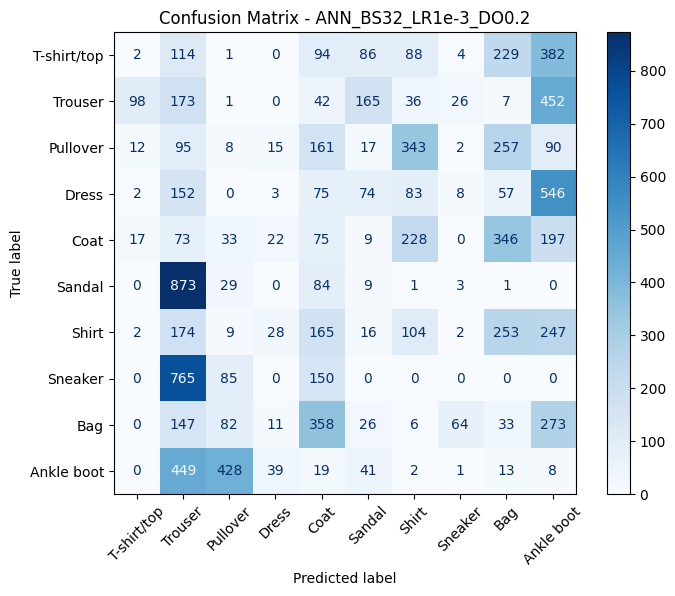

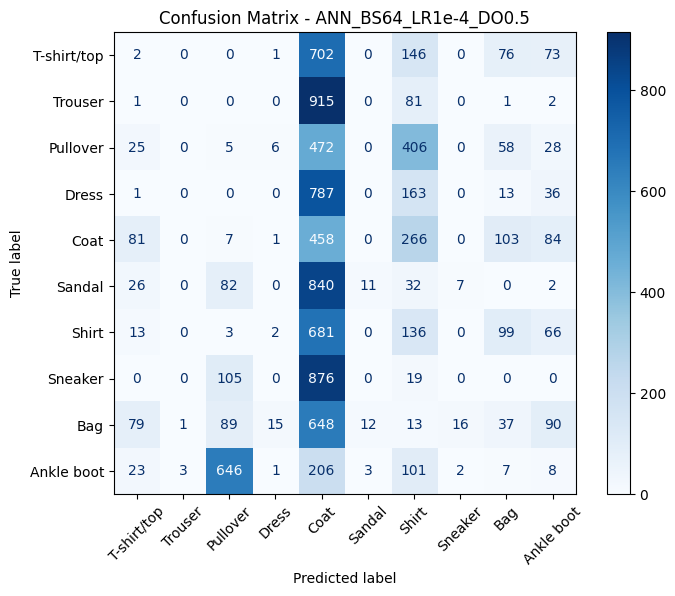

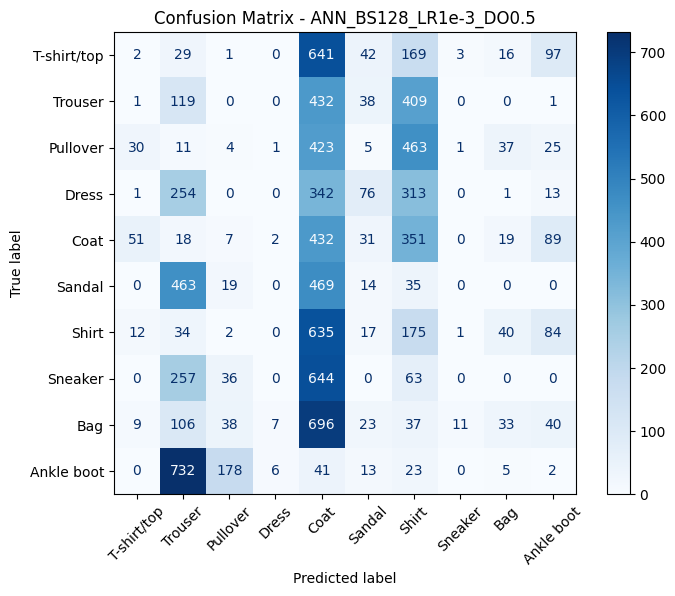

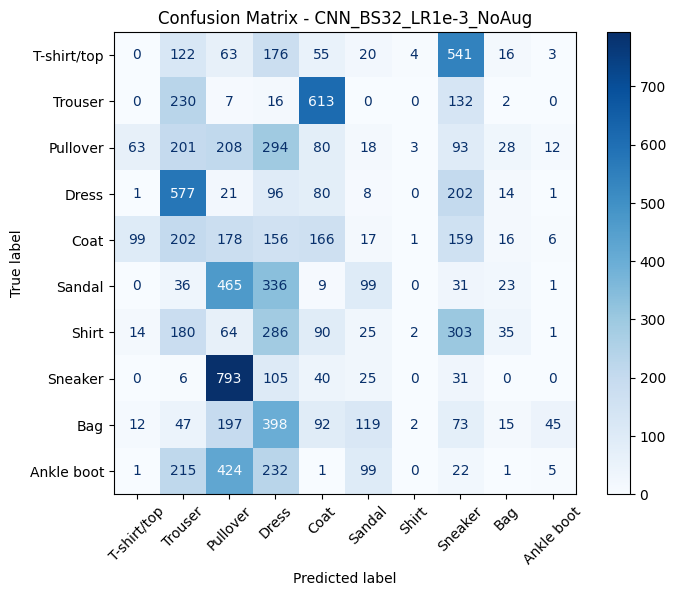

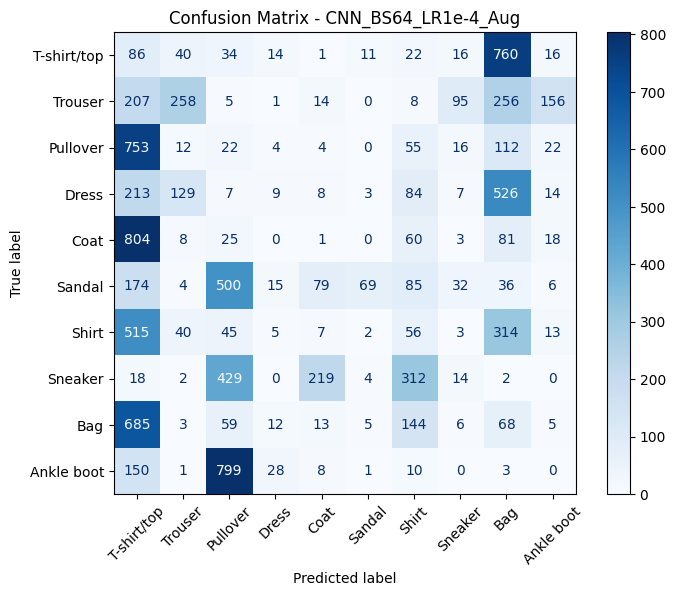

In [ ]:
for name, model in trained_models.items():
    plot_conf_matrix(model, name)


,Model,Train Acc (%),Test Acc (%),Train Loss,Test Loss,Training Time (s),Overfitting Gap (%)
0,ANN_BS32_LR1e-3_DO0.2,98.49,97.92,0.0480,0.0707,107.61,0.57
1,ANN_BS64_LR1e-4_DO0.5,93.90,96.01,0.2344,0.1366,83.29,-2.11
2,ANN_BS128_LR1e-3_DO0.5,96.46,97.63,0.1326,0.0816,72.03,-1.17
3,CNN_BS32_LR1e-3_NoAug,97.42,99.09,0.0863,0.0301,120.02,-1.67
4,CNN_BS64_LR1e-4_Aug,91.11,58.12,0.2816,1.1683,257.14,32.99


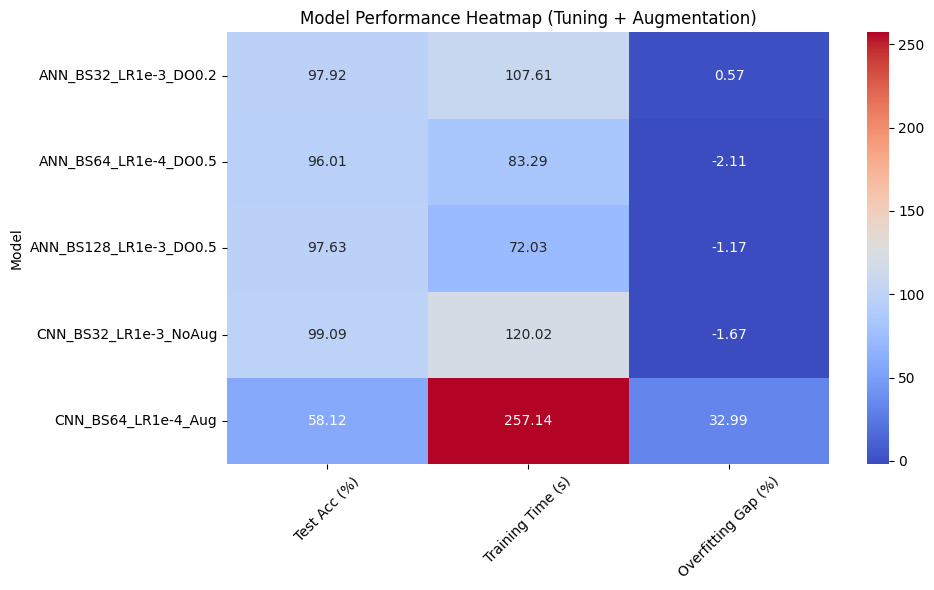

In [ ]:
def generate_results_table(results):
    rows = []
    for name, r in results.items():
        rows.append({
            'Model': name,
            'Train Acc (%)': round(r['train_acc'][-1] * 100, 2),
            'Test Acc (%)': round(r['test_acc'][-1] * 100, 2),
            'Train Loss': round(r['train_losses'][-1], 4),
            'Test Loss': round(r['test_losses'][-1], 4),
            'Training Time (s)': round(r['training_time'], 2),
            'Overfitting Gap (%)': round((r['train_acc'][-1] - r['test_acc'][-1]) * 100, 2)
        })
    return pd.DataFrame(rows)

# Table
tuned_df = generate_results_table(tuned_results)
display(tuned_df)

# Heatmap
plt.figure(figsize=(10, 6))
heatmap_data = tuned_df.set_index('Model')[['Test Acc (%)', 'Training Time (s)', 'Overfitting Gap (%)']]
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Model Performance Heatmap (Tuning + Augmentation)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
